In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as smf



In [121]:
#read in movie data
df = pd.read_csv('movie_metadata.csv')


## Data Cleaning

In [122]:


#create profit column
df['profit'] = df['gross'] - df['budget']


In [123]:
#remove missing values
df = df.drop(columns=['color'])
n_original = len(df)
df.dropna(inplace=True)
n_null_removed = len(df)
print("original size, new size: "+ str(n_original)+", " +str(n_null_removed))


original size, new size: 5043, 3757


In [124]:
#remove outliers of profit within 3 standard deviations
df = df[df['profit'] < 3*df['profit'].std()]
df = df[df['profit'] > -3*df['profit'].std()]

In [125]:
df["title_year"] = df["title_year"].astype(int)


## EDA

In [126]:
# create bins based on quartiles of the "gross" variable
df['gross_bin'] = pd.qcut(df['gross'], 4, labels=False)
# normalize "gross_bins" to have values in the range [0, 1]
df['gross_bin'] = df['gross_bin'] / df['gross_bin'].max()


In [127]:
df['gross_bin'].value_counts()

1.000000    937
0.666667    937
0.000000    937
0.333333    937
Name: gross_bin, dtype: int64

In [128]:
df["title_year"] = df["title_year"].astype(int)


### Genres

In [129]:
# create binary variables for each genre
genres_df = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genres_df], axis=1)

#lowercase column names
df.columns = map(str.lower, df.columns)

df = df.rename(columns={'sci-fi': 'sci_fi'})

#remove rows having genres with combiend revenue = 0 (film_noir,,game_shwo, reality_tv)

df = df[df['genres'] != 'film_noir']
df = df[df['genres'] != 'game_show']
df = df[df['genres'] != 'reality_tv']
#remove genres column



### Actors


In [130]:
df_people = df[["director_name", "director_facebook_likes",  "actor_1_name", "actor_1_facebook_likes","actor_2_name", "actor_2_facebook_likes", "actor_3_name","actor_3_facebook_likes", "cast_total_facebook_likes",  "profit"]]
yay = df_people.groupby(["director_name","actor_1_name", "actor_2_name", "actor_3_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False)
df_people.groupby(["director_name","actor_1_name", "actor_2_name", "actor_3_name"]).agg("count")
director = df_people.groupby(["director_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_1 = df_people.groupby(["actor_1_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_2 = df_people.groupby(["actor_2_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_3 = df_people.groupby(["actor_3_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
director_high = [x for x in director['director_name'].iloc[:(round(len(director)/2))]]
director_low = [x for x in director['director_name'].iloc[(round(len(director)/2)):len(director)]]
actor_1_high = [x for x in actor_1['actor_1_name'].iloc[:(round(len(actor_1)/2))]]
actor_1_low = [x for x in actor_1['actor_1_name'].iloc[(round(len(actor_1)/2)):len(actor_1)]]
actor_2_high = [x for x in actor_2['actor_2_name'].iloc[:(round(len(actor_2)/2))]]
actor_2_low = [x for x in actor_2['actor_2_name'].iloc[(round(len(actor_2)/2)):len(actor_2)]]
actor_3_high = [x for x in actor_3['actor_3_name'].iloc[:(round(len(actor_3)/2))]]
actor_3_low = [x for x in actor_3['actor_3_name'].iloc[(round(len(actor_3)/2)):len(actor_3)]]
df["director_high"] = [1 if director_high.count(x) > 0 else 0 for x in df["director_name"]]
df["director_low"] = [1 if director_low.count(x) > 0 else 0 for x in df["director_name"]]
df["actor_1_high"] = [1 if actor_1_high.count(x) > 0 else 0 for x in df["actor_1_name"]]
df["actor_1_low"] = [1 if actor_1_low.count(x) > 0 else 0 for x in df["actor_1_name"]]
df["actor_2_high"] = [1 if actor_2_high.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_low"] = [1 if actor_2_low.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_high"] = [1 if actor_2_high.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_low"] = [1 if actor_2_low.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_3_high"] = [1 if actor_3_high.count(x) > 0 else 0 for x in df["actor_3_name"]]
df["actor_3_low"] = [1 if actor_3_low.count(x) > 0 else 0 for x in df["actor_3_name"]]

In [131]:
df["is_english"] = [1 if x == "English" else 0 for x in df["language"]]


### Binary Profit

In [132]:
df['profit_binary'] = np.where(df['profit'] > 0, 1, 0)


### Remove Post Release Metrics


In [133]:
post_release_metrics = ['imdb_score', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'movie_facebook_likes']
df = df.drop(columns=post_release_metrics)

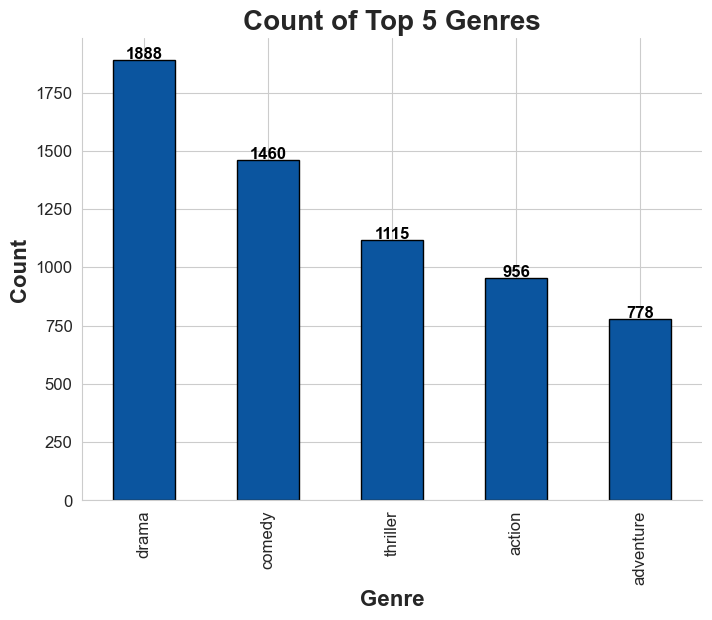

In [134]:
#plot count of each genre for top 5 genres
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 5 genres
top_genres = df[['action', 'adventure', 'comedy', 'drama', 'thriller']].sum().sort_values(ascending=False).head(5)

# Set style and colors
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

# Plot bar chart
ax = top_genres.plot(kind='bar', figsize=(8, 6), edgecolor='black')

# Set titles and labels
ax.set_title("Count of Top 5 Genres", fontsize=20, fontweight='bold')
ax.set_xlabel("Genre", fontsize=16, fontweight='bold')
ax.set_ylabel("Count", fontsize=16, fontweight='bold')

# Set tick label font size
ax.tick_params(labelsize=12)

# Remove top and right spines
sns.despine(top=True, right=True)

# Add value labels to each bar
for i, v in enumerate(top_genres):
    ax.text(i, v + 5, str(v), color='black', fontweight='bold', ha='center', fontsize=12)

plt.show()


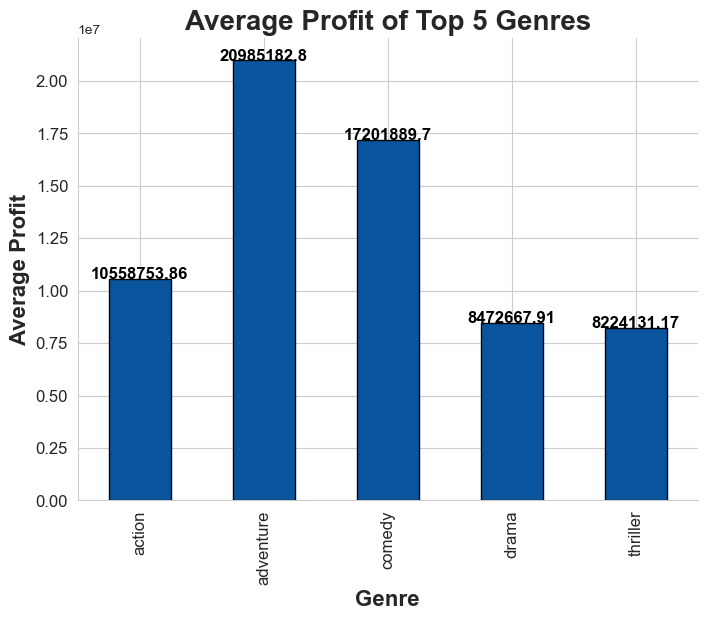

In [140]:
import matplotlib.pyplot as plt

# Select the top 5 genres
top_genres = ['action', 'adventure', 'comedy', 'drama', 'thriller']

#avg profit for each genre in top 5 genres

avg_profit = []
for genre in top_genres:
    avg_profit.append(df[df[genre] == 1]['profit'].mean())


# Set style and colors
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

# Plot bar chart
ax = pd.Series(avg_profit, index=top_genres).plot(kind='bar', figsize=(8, 6), edgecolor='black')

# Set titles and labels
ax.set_title("Average Profit of Top 5 Genres", fontsize=20, fontweight='bold')
ax.set_xlabel("Genre", fontsize=16, fontweight='bold')
ax.set_ylabel("Average Profit", fontsize=16, fontweight='bold')

# Set tick label font size
ax.tick_params(labelsize=12)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()




In [ ]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Save the training and testing data as CSV files
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

In [ ]:
#export cleaned_data
df = df.drop(columns=['genres'])
df.to_csv('cleaned_data.csv', index=False)
